In [1]:
import keras
import numpy as np
from keras.models import Sequential, Model
from keras.layers import Dense, Reshape, Flatten, Input, Dropout, LSTM, MultiHeadAttention, GlobalAveragePooling1D
from keras.optimizers import Adam, SGD, RMSprop
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.applications import xception
import tensorflow as tf
import alibi
from alibi.explainers import IntegratedGradients

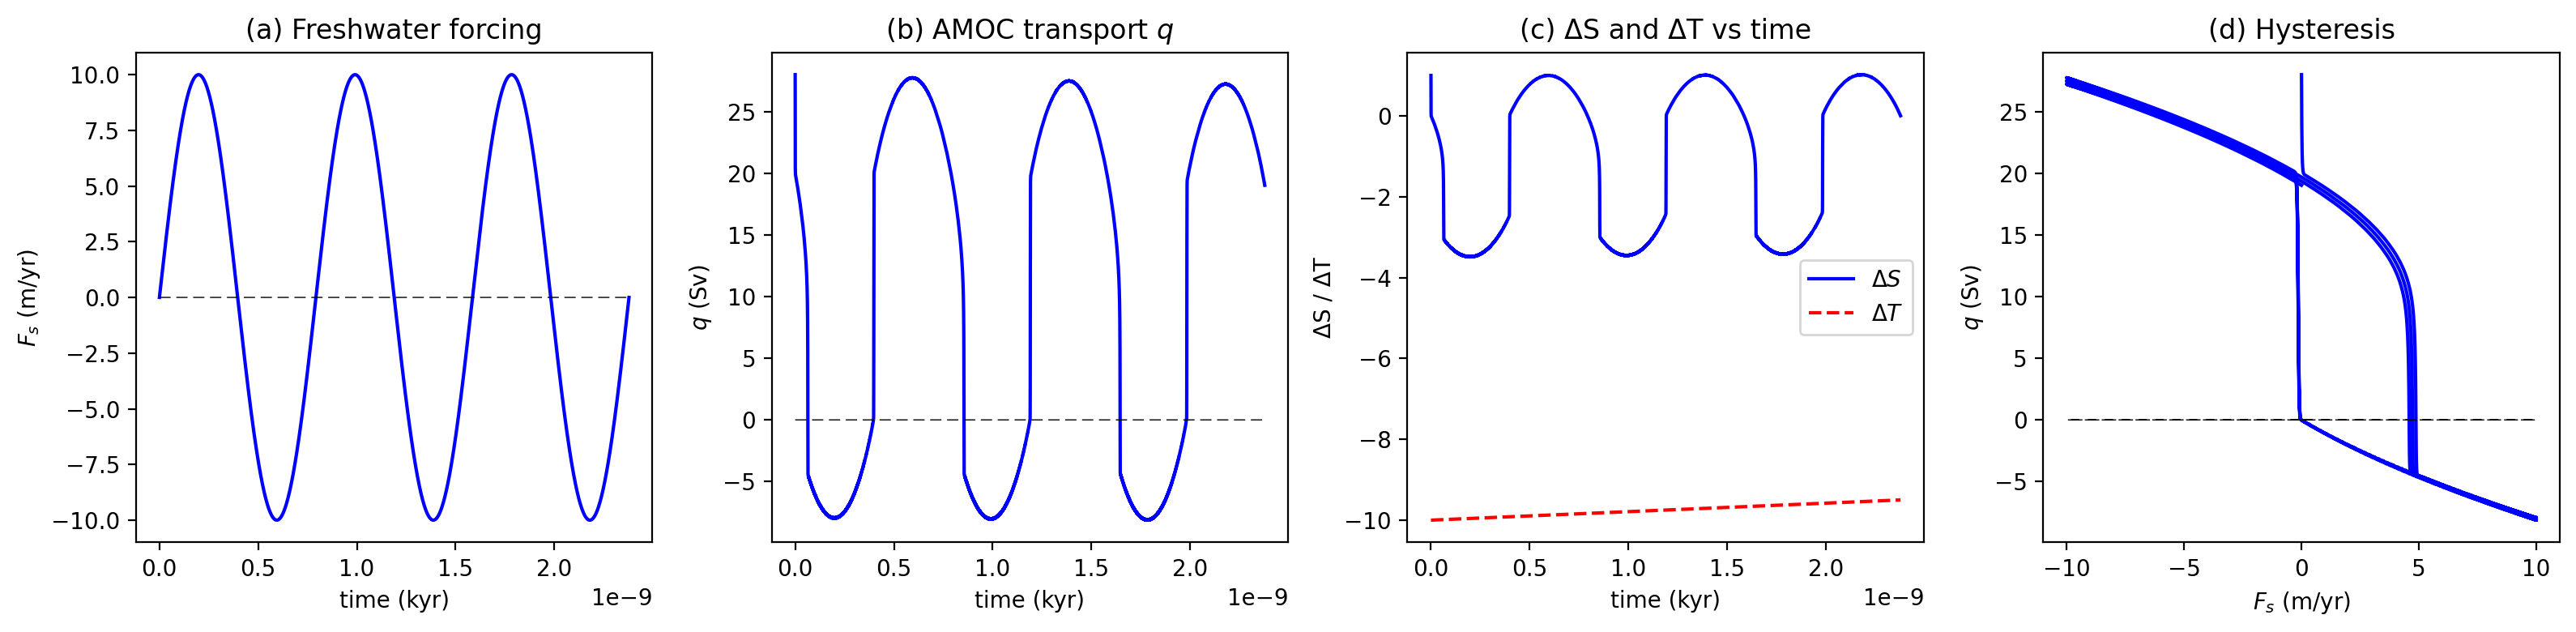

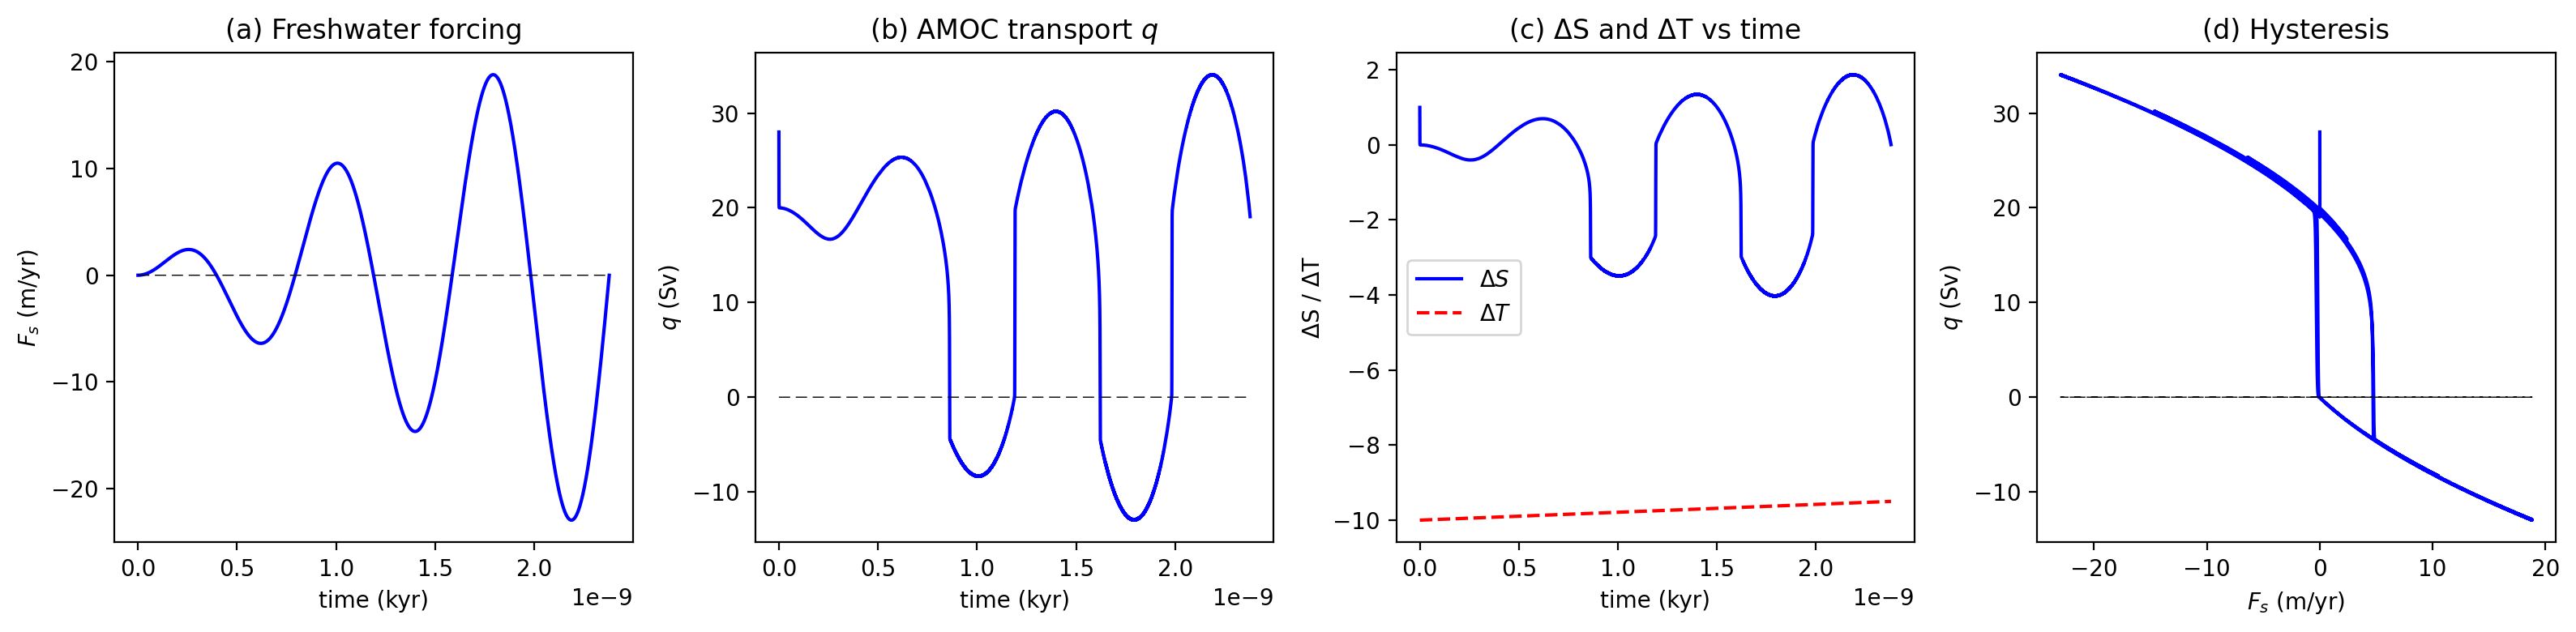

In [2]:
%run 00_generate_data.ipynb

In [3]:
input_data, output_data, qplot = get_data("s")

In [4]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

# MLP

In [5]:
# More samples where AMOC changes rapidly (derivatives)
qplot_smooth = qplot/Sv
q_gradient = np.abs(np.gradient(qplot_smooth))

# Higher sampling probability where gradient is high

gradient_probs = q_gradient / q_gradient.sum()
np.random.seed(42)
sample_indices = np.random.choice(len(qplot), size=250, replace=False, p=gradient_probs)

In [6]:
def build_mlp():
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [7]:
ig_mlp_ensemble = []

In [8]:
for i in range(12):
    model = build_mlp()
    model.load_weights(f'models/mlp/stationary/ensemble_member_{i}.keras')
    ig  = IntegratedGradients(model,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=25)
    predicted_test = (model.predict(input_scaled[sample_indices]) > 0.5).astype(int).flatten()
    explanation = ig.explain(input_scaled[sample_indices],
                         baselines=None,
                         target=predicted_test)

    attributions = explanation.attributions
    ig_mlp_ensemble.append(attributions)
    print(np.array(ig_mlp_ensemble).shape)
    print(f'Computed for model {i}')

8/8 [==============================] - 0s 1ms/step
(1, 1, 250, 4)
Computed for model 0
8/8 [==============================] - 0s 1ms/step
(2, 1, 250, 4)
Computed for model 1
8/8 [==============================] - 0s 2ms/step
(3, 1, 250, 4)
Computed for model 2
8/8 [==============================] - 0s 1ms/step
(4, 1, 250, 4)
Computed for model 3
8/8 [==============================] - 0s 1ms/step
(5, 1, 250, 4)
Computed for model 4
8/8 [==============================] - 0s 1ms/step
(6, 1, 250, 4)
Computed for model 5
8/8 [==============================] - 0s 1ms/step
(7, 1, 250, 4)
Computed for model 6
8/8 [==============================] - 0s 1ms/step
(8, 1, 250, 4)
Computed for model 7
8/8 [==============================] - 0s 1ms/step
(9, 1, 250, 4)
Computed for model 8
8/8 [==============================] - 0s 1ms/step
(10, 1, 250, 4)
Computed for model 9
8/8 [==============================] - 0s 1ms/step
(11, 1, 250, 4)
Computed for model 10
8/8 [==============================] - 0

In [18]:
ig_array_mean.shape

(250, 4)

In [9]:
ig_array_mlp = np.array(ig_mlp_ensemble)[:, 0, :, :]

In [10]:
ig_array_mean = np.array(ig_mlp_ensemble).mean(axis=0)[0]

In [19]:
ig_sal = ig_array_mean[:, 1]
ig_temp = ig_array_mean[:, 2]

In [20]:
ig_sal.shape

(250,)

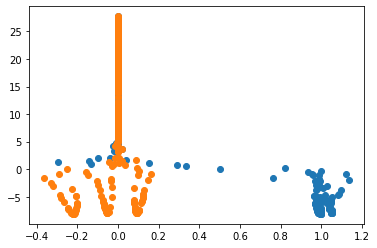

In [21]:
plt.scatter(ig_sal, qplot[sample_indices]/Sv);
plt.scatter(ig_temp, qplot[sample_indices]/Sv);

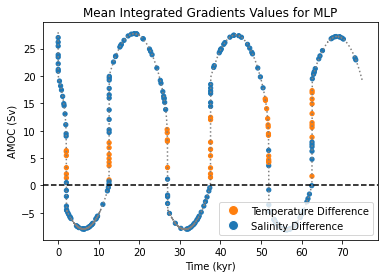

In [22]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(ig_temp > ig_sal, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, marker='o', c=colors, s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean Integrated Gradients Values for MLP')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')
fig.savefig('figures/ig/ig_mean_mlp.pdf')

In [24]:
ig_array_mlp[0].shape

(250, 4)

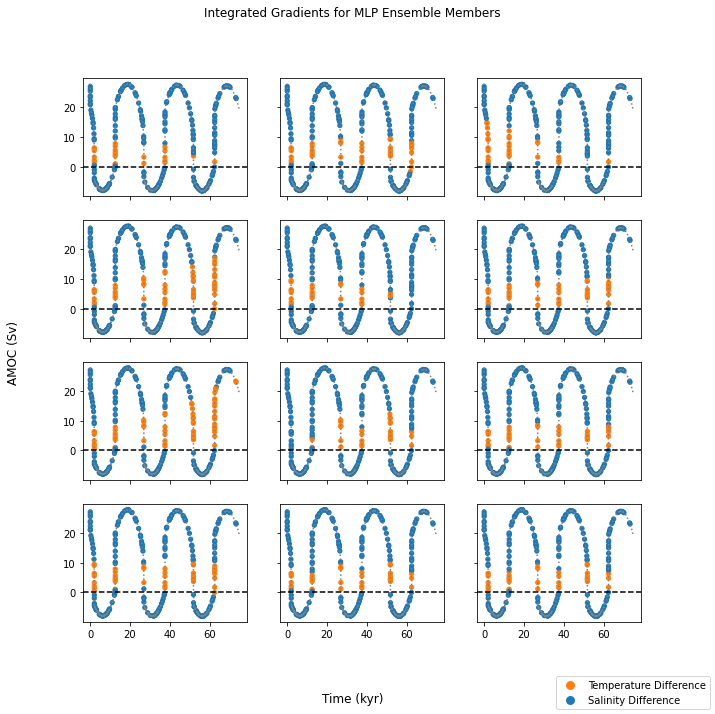

In [27]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Integrated Gradients for MLP Ensemble Members')
ax = ax.flatten()

for i in range(12):
    ig_ensemble_i = ig_array_mlp[i]
    ig_sal = ig_ensemble_i[:, 1]
    ig_temp = ig_ensemble_i[:, 2]
    colors = np.where(ig_temp > ig_sal, '#ff7f0e', '#1f77b4')

    # Single scatter call
    scatter = ax[i].scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, marker='o', c=colors, s=18)
    ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
    ax[i].axhline(0, color='black', linestyle='--')

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#1f77b4', markersize=10)
]
fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
           loc='lower right')

fig.savefig('figures/ig/ig_ensemble_mlp.pdf')

# NONSTATIONARY

In [29]:
input_data, output_data, qplot = get_data("ns")

In [30]:
X_train = input_data[0:60032]
y_train = output_data[0:60032]

X_val = input_data[61024:81000]
y_val = output_data[61024:81000]

X_test = input_data[81992:100000]
y_test = output_data[81992:100000]

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)
input_scaled = scaler.transform(input_data)

In [31]:
# More samples where AMOC changes rapidly (derivatives)
qplot_smooth = qplot/Sv
q_gradient = np.abs(np.gradient(qplot_smooth))

# Higher sampling probability where gradient is high

gradient_probs = q_gradient / q_gradient.sum()
np.random.seed(42)
sample_indices = np.random.choice(len(qplot), size=250, replace=False, p=gradient_probs)

In [32]:
def build_mlp():
    model = Sequential()
    model.add(Dense(4, input_dim=4, activation='relu'))
    model.add(Dense(2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [33]:
ig_mlp_ensemble_ns = []

In [34]:
for i in range(12):
    model = build_mlp()
    model.load_weights(f'models/mlp/nonstationary/ensemble_member_{i}.keras')
    ig  = IntegratedGradients(model,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=25)
    predicted_test = (model.predict(input_scaled[sample_indices]) > 0.5).astype(int).flatten()
    explanation = ig.explain(input_scaled[sample_indices],
                         baselines=None,
                         target=predicted_test)

    attributions = explanation.attributions
    ig_mlp_ensemble_ns.append(attributions)
    print(np.array(ig_mlp_ensemble_ns).shape)
    print(f'Computed for model {i}')

8/8 [==============================] - 0s 1ms/step
(1, 1, 250, 4)
Computed for model 0
8/8 [==============================] - 0s 1ms/step
(2, 1, 250, 4)
Computed for model 1
8/8 [==============================] - 0s 1ms/step
(3, 1, 250, 4)
Computed for model 2
8/8 [==============================] - 0s 1ms/step
(4, 1, 250, 4)
Computed for model 3
8/8 [==============================] - 0s 1ms/step
(5, 1, 250, 4)
Computed for model 4
8/8 [==============================] - 0s 1ms/step
(6, 1, 250, 4)
Computed for model 5
8/8 [==============================] - 0s 1ms/step
(7, 1, 250, 4)
Computed for model 6
8/8 [==============================] - 0s 1ms/step
(8, 1, 250, 4)
Computed for model 7
8/8 [==============================] - 0s 1ms/step
(9, 1, 250, 4)
Computed for model 8
8/8 [==============================] - 0s 1ms/step
(10, 1, 250, 4)
Computed for model 9
8/8 [==============================] - 0s 1ms/step
(11, 1, 250, 4)
Computed for model 10
8/8 [==============================] - 0

In [35]:
ig_array_mlp_ns = np.array(ig_mlp_ensemble_ns)[:, 0, :, :]

In [36]:
ig_array_mean_ns = np.array(ig_mlp_ensemble_ns).mean(axis=0)[0]

In [37]:
ig_sal_ns = ig_array_mean_ns[:, 1]
ig_temp_ns = ig_array_mean_ns[:, 2]

In [38]:
ig_sal_ns.shape

(250,)

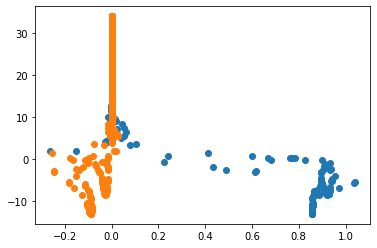

In [39]:
plt.scatter(ig_sal_ns, qplot[sample_indices]/Sv);
plt.scatter(ig_temp_ns, qplot[sample_indices]/Sv);

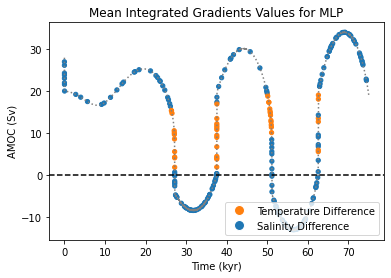

In [40]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(ig_temp_ns > ig_sal_ns, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, marker='o', c=colors, s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('Mean Integrated Gradients Values for MLP')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')
fig.savefig('figures/ig/ig_mean_mlp_ns.pdf')

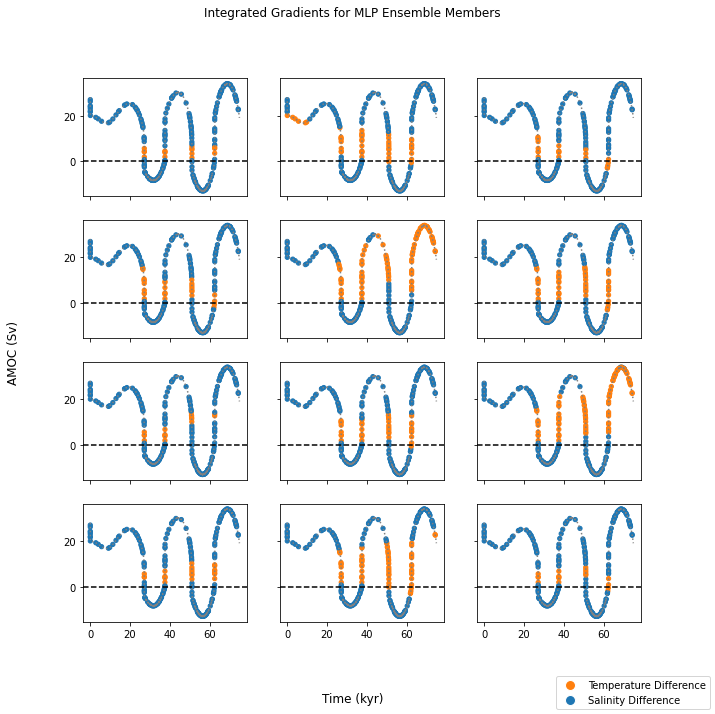

In [41]:
fig, ax = plt.subplots(4, 3, sharex = True, sharey = True, figsize = (10, 10))
fig.supxlabel('Time (kyr)')
fig.supylabel('AMOC (Sv)')
fig.suptitle('Integrated Gradients for MLP Ensemble Members')
ax = ax.flatten()

for i in range(12):
    ig_ensemble_i = ig_array_mlp_ns[i]
    ig_sal = ig_ensemble_i[:, 1]
    ig_temp = ig_ensemble_i[:, 2]
    colors = np.where(ig_temp > ig_sal, '#ff7f0e', '#1f77b4')

    # Single scatter call
    scatter = ax[i].scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, marker='o', c=colors, s=18)
    ax[i].plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
    ax[i].axhline(0, color='black', linestyle='--')

legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#ff7f0e', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', 
               markerfacecolor='#1f77b4', markersize=10)
]
fig.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
           loc='lower right')

fig.savefig('figures/ig/ig_ensemble_mlp_ns.pdf')

# LSTM

In [28]:
def create_sequences(data, labels, time_steps):
    sequences, sequence_labels = [], []
    for i in range(len(data) - time_steps + 1):
        sequences.append(data[i:i + time_steps])
        sequence_labels.append(labels[i + time_steps - 1])  # Label at the end of the sequence
    return np.array(sequences), np.array(sequence_labels)

time_steps = 16
feature_dim = 4

# Create sequences
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)
input_seq, output_seq = create_sequences(input_scaled, output_data, time_steps)

In [64]:
model = Sequential([
    LSTM(8, input_shape=(time_steps, feature_dim), return_sequences=False),
    Dense(4, activation='relu'),
    Dense(2, activation='relu'),
    Dense(1, activation='sigmoid') 
    ])
model.load_weights('models/lstm/stationary/ensemble_member_0.keras')

In [65]:
ig  = IntegratedGradients(model,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=25)

In [66]:
predicted_test = (model.predict(input_seq[sample_indices]) > 0.5).astype(int).flatten()

8/8 [==============================] - 0s 2ms/step


In [67]:
predicted_test

array([1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1])

In [68]:
explanation = ig.explain(input_seq[sample_indices],
                         baselines=None,
                         target=predicted_test)

attributions = explanation.attributions

In [71]:
np.array(attributions)[0].mean(axis=1).shape

(250, 4)

In [72]:
ig_array = np.array(attributions)[0].mean(axis=1)

In [73]:
ig_sal = ig_array[:, 1]
ig_temp = ig_array[:, 2]

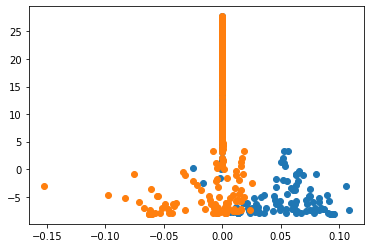

In [74]:
plt.scatter(ig_sal, qplot[sample_indices]/Sv);
plt.scatter(ig_temp, qplot[sample_indices]/Sv);

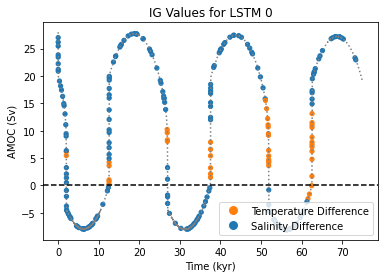

In [75]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(ig_temp > ig_sal, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, marker='o', c=colors, s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('IG Values for LSTM 0')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')

# Transformer

In [76]:
def build_transformer():
    inputs = Input(shape=(None, feature_dim))  # None allows variable sequence length
    
   
    attention_output = MultiHeadAttention(
        num_heads=4,
        key_dim=4,
        dropout=0.1
    )(inputs, inputs)  

    pooled = GlobalAveragePooling1D()(attention_output)

    x = Dense(16, activation='relu')(pooled)
    x = Dense(8, activation='relu')(x)
    x = Dense(4, activation='relu')(x)
    x = Dense(2, activation='relu')(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=outputs)
    
    return model 

In [77]:
model = build_transformer()
model.load_weights('models/transformer/stationary/ensemble_member_0.keras')

In [78]:
ig  = IntegratedGradients(model,
                          method="gausslegendre",
                          n_steps=50,
                          internal_batch_size=25)

In [79]:
predicted_test = (model.predict(input_seq[sample_indices]) > 0.5).astype(int).flatten()

8/8 [==============================] - 0s 2ms/step


In [80]:
predicted_test

array([1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1])

In [81]:
explanation = ig.explain(input_seq[sample_indices],
                         baselines=None,
                         target=predicted_test)

attributions = explanation.attributions

In [83]:
np.array(attributions)[0].mean(axis=1).shape

(250, 4)

In [84]:
ig_array = np.array(attributions)[0].mean(axis=1)

In [85]:
ig_sal = ig_array[:, 1]
ig_temp = ig_array[:, 2]

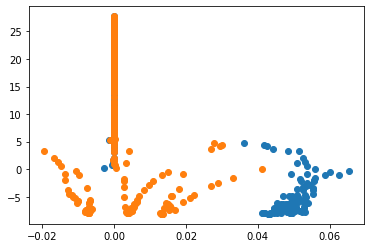

In [86]:
plt.scatter(ig_sal, qplot[sample_indices]/Sv);
plt.scatter(ig_temp, qplot[sample_indices]/Sv);

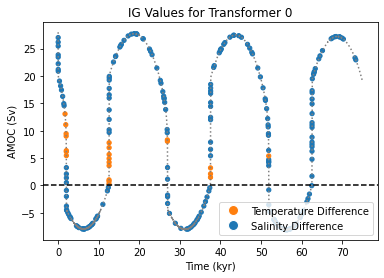

In [87]:
fig, ax = plt.subplots()

# Create color array
colors = np.where(ig_temp > ig_sal, '#ff7f0e', '#1f77b4')

# Single scatter call
scatter = ax.scatter(input_data[sample_indices, 0], qplot[sample_indices]/Sv, marker='o', c=colors, s=18)

ax.set_xlabel('Time (kyr)')
ax.set_ylabel('AMOC (Sv)')
ax.set_title('IG Values for Transformer 0')
ax.plot(input_data[:, 0], qplot/Sv, linestyle=':', color='grey')
ax.axhline(0, color='black', linestyle='--')

# Manual legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#ff7f0e', markersize=10),
                 plt.Line2D([0], [0], marker='o', color='w', 
                            markerfacecolor='#1f77b4', markersize=10)]
ax.legend(legend_handles, ['Temperature Difference', 'Salinity Difference'], 
          loc='lower right')